## PS 8

names: Jaden, Marco, Tyler, Matthew 

In [1]:
! pip install interpolation
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from scipy.optimize import minimize_scalar, bisect
plt.rcParams["figure.figsize"] = (10, 5)  # Set default figure size


## Problem 1

In [2]:
def solve_parking(n=100, no_spot=-500, p=0.2, max_iter=1000, verbose=False):
    """
    We have two 'modes' (or states):
      - V[0]: The value if we still have the option to park (i.e., we see an open spot).
      - V[1]: The value if no spot is currently available (we must continue driving).

    The state space is indexed by integers i from -n to +n, 
    stored in a 1D array of length 2n+1. 
      - i = 0 corresponds to "distance = -n" in that array
      - i = n corresponds to "distance = 0" (our destination)
      - i = 2n corresponds to "distance = +n"

    The code updates the value functions by either parking now
    or continuing on to the next spot.  'no_spot' is a large negative
    penalty if we end up with no spot by the time we are forced to stop.
    """

    # 1. Initialize the value functions for each 'mode':
    #    - V[0]: starts as -|distance| for each state
    #    - V[1]: starts as a constant "no_spot" for each state
    #             (representing a bad outcome if you end up never parking)
    # 2. We'll iterate the Bellman updates up to max_iter times.

    V = [
        -abs(np.arange(-n, n+1)),         # shape (2n+1,)
        no_spot * np.ones(2*n + 1)        # shape (2n+1,)
    ]

    # Optional: keep track of the “park vs. skip” policy in V[0]
    policy_park = np.zeros(2*n + 1, dtype=int)

    for iteration in range(max_iter):

        # Update the "park-or-skip" state for indices 0..(n-1).
        #  These correspond to states from -n up to -1 in the array.
        old_park_values = V[0][:n].copy()

        # If we skip, next state is i+1. Probability p that it’s an open spot (V[0]),
        # and (1-p) that it’s still no spot (V[1]).
        skip_vals = p * V[0][1:n+1] + (1 - p) * V[1][1:n+1]

        # Compare "park now" (which yields V[0][i] as is) vs. "skip" (skip_vals).
        V[0][:n] = np.maximum(V[0][:n], skip_vals)

        # Record the policy: 1 if "park now" is better, else 0
        park_better = old_park_values >= skip_vals
        policy_park[:n] = park_better.astype(int)

        # Update the "no-spot" state (V[1]) for indices 0..(2n-1).
        # If we have no spot, we can’t choose anything, so just the expected next value.
        V[1][:-1] = p * V[0][1:] + (1 - p) * V[1][1:]

    if verbose:
        print(f"Converged after {max_iter} iterations (or hit iteration limit).")

    # Print the value at the leftmost state (index 0 => distance = -n).
    print("Value at the leftmost state (index 0):", V[0][0])

    return V, policy_park

1.) State space includes location (distance from office) and whether a spot is open.
2.) Control is: “Park now” vs. “Skip” (continue).


## Problem 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from scipy.optimize import minimize_scalar, bisect

class CakeEating:

    def __init__(self,
                 β=0.97,           # discount factor
                 γ=2,             # CRRA parameter
                 x_grid_min=1e-3, # min. cake
                 x_grid_max=10,   # max. cake
                 x_grid_size=120,
                 μ=-0.005,        # mean of log-shock
                 s=0.1,           # std. dev. of log-shock
                 shock_size=250):

        self.β, self.γ = β, γ
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

        # Generate lognormal-ish shocks
        np.random.seed(1234)
        self.shock_size = shock_size
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def u(self, c):
        if self.γ == 1:
            return np.log(c)
        else:
            return c**(1 - self.γ) / (1 - self.γ)

    def u_prime(self, c):
        return c**(-self.γ)


def maximize(g, a, b, args=()):
    """
    Helper to maximize g over [a, b] by minimizing -g.
    """
    def objective(x):
        return -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    return result.x, -result.fun


def K(σ_array, ce):
    """
    Euler-equation-based policy-function operator:
      u'(c) = β * E[ u'(σ( (x - c)*shock )) ].
    """
    x_grid = ce.x_grid
    shocks = ce.shocks
    β, u_prime = ce.β, ce.u_prime

    σ_new = np.empty_like(σ_array)

    for i, x in enumerate(x_grid):
        if x < 1e-12:
            σ_new[i] = 0.0
            continue

        def euler_diff(c):
            # Interpolate current guess for next consumption
            σ_func = lambda z: interp(x_grid, σ_array, z)
            # Right side: β * E[u'(σ( (x-c)*shock ))]
            rhs = β * np.mean([u_prime(σ_func((x - c) * s)) for s in shocks])
            return u_prime(c) - rhs

        # We attempt a root find on [1e-10, x - 1e-10]
        c_low, c_high = 1e-10, x - 1e-10
        f_low, f_high = euler_diff(c_low), euler_diff(c_high)

        # If there's no sign change, fallback to the deterministic closed-form guess
        if f_low * f_high > 0:
            guess = (1 - ce.β**(1/ce.γ)) * x
            σ_new[i] = guess
        else:
            # We have a sign change, so we can do bisect
            σ_new[i] = bisect(euler_diff, c_low, c_high)

    return σ_new


def iterate_euler_equation(ce, max_iter=5000, tol=1e-5, verbose=True, print_skip=100):
    x_grid = ce.x_grid
    σ = np.copy(x_grid)  # initial guess: consume everything (or any feasible guess)

    error = tol + 1
    it = 0
    while it < max_iter and error > tol:
        σ_new = K(σ, ce)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        it += 1
        if verbose and it % print_skip == 0:
            print(f"Iteration {it}: error = {error}")

    if error > tol:
        print(f"Euler-equation iteration did NOT fully converge (final error={error:.3e}).")
    else:
        if verbose:
            print(f"Converged in {it} iterations with error {error:.2e}.")

    return σ


def c_star(x, β, γ):
    """
    Deterministic closed-form solution for CRRA with parameter γ != 1:
      c*(x) = (1 - β^(1/γ)) * x
    """
    return (1 - β**(1/γ)) * x

Answers

=== Problem 1: Parking Problem ===
DESCRIBE THIS PROBLEM AS A DYNAMIC PROGRAM:

1) The State:
   - The state is (distance, spot_availability),
     where 'distance' can be indexed from -n to +n,
     and 'spot_availability' is either 'open' or 'not open'.
   - In code, we represent the distance from -n to n in an array of length 2n+1.
     We also store two value arrays: V[0] if a spot is open, V[1] if no spot is open.

2) The Control:
   - The control is a binary choice: 'park now' or 'skip'.
   - If a spot is open, you can choose to park immediately or pass it up.
   - If no spot is open, there is no control choice; you must drive on.

3) The Law of Motion:
   - If you skip when a spot is open, with probability p you remain in a state
     where a spot is open (just one step closer), and with probability (1-p)
     you transition to a state with no spot (also one step closer).
   - If you are in 'no spot' mode, you stay in 'no spot' mode with probability (1-p)
     or move to 'open s

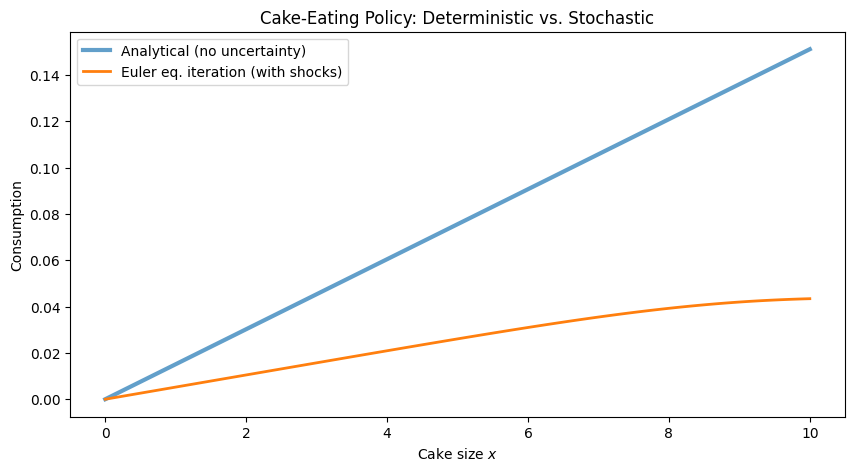

In [4]:
# =========================
# PROBLEM 1 & PROBLEM 2
# =========================
np.random.seed(1234)
def main():
    # ------------------------------------------------------
    #  ANSWERS TO THE QUESTIONS FOR PROBLEM 1: PARKING
    # ------------------------------------------------------
    print("=== Problem 1: Parking Problem ===")
    print("DESCRIBE THIS PROBLEM AS A DYNAMIC PROGRAM:\n")
    
    # 1. What is the state?
    print("1) The State:")
    print("   - The state is (distance, spot_availability),")
    print("     where 'distance' can be indexed from -n to +n,")
    print("     and 'spot_availability' is either 'open' or 'not open'.")
    print("   - In code, we represent the distance from -n to n in an array of length 2n+1.")
    print("     We also store two value arrays: V[0] if a spot is open, V[1] if no spot is open.\n")
    
    # 2. What is the control?
    print("2) The Control:")
    print("   - The control is a binary choice: 'park now' or 'skip'.")
    print("   - If a spot is open, you can choose to park immediately or pass it up.")
    print("   - If no spot is open, there is no control choice; you must drive on.\n")
    
    # 3. What is the law of motion?
    print("3) The Law of Motion:")
    print("   - If you skip when a spot is open, with probability p you remain in a state")
    print("     where a spot is open (just one step closer), and with probability (1-p)")
    print("     you transition to a state with no spot (also one step closer).")
    print("   - If you are in 'no spot' mode, you stay in 'no spot' mode with probability (1-p)")
    print("     or move to 'open spot' mode with probability p, again one step closer.\n")
    
    # 4. What is the reward?
    print("4) The Reward:")
    print("   - Parking at distance d yields a payoff of -|d| (a negative cost of walking).")
    print("   - If you reach distance 0 without parking, you incur a large negative payoff (no_spot = -500).")
    print("   - Hence, the immediate payoff depends on your distance if you park now, or 0 if you skip.\n")
    
    # 5. What is the discount factor?
    print("5) The Discount Factor:")
    print("   - In this assignment, we do not explicitly discount across states; we do a one-shot cost.")
    print("     If we interpret each step as a stage, we could treat it as a discount factor of 1.0,")
    print("     or treat time as discrete steps. In the code, we effectively incorporate a finite horizon.")
    print("   - Alternatively, you can interpret the repeated stepping as a cost that accumulates with no discount.\n")
    
    # Now run the parking code
    V, policy_park = solve_parking(n=100, no_spot=-500, p=0.2, max_iter=1000, verbose=False)

    # Show some policy results
    print("Parking policy (first 10 states):", policy_park[:10])
    print("Value at the leftmost state (index 0):", V[0][0], "\n")

    # ------------------------------------------------------
    #  ANSWERS TO THE QUESTIONS FOR PROBLEM 2: CAKE-EATING
    # ------------------------------------------------------
    print("=== Problem 2: Cake-Eating Problem ===")
    print("DESCRIBE THIS PROBLEM AS A DYNAMIC PROGRAM:\n")
    
    # 1. What is the state?
    print("1) The State:")
    print("   - The state is the current cake size x ≥ 0.\n")
    
    # 2. What is the control?
    print("2) The Control:")
    print("   - The control is the consumption c in [0, x].\n")
    
    # 3. What is the law of motion?
    print("3) The Law of Motion:")
    print("   - After consuming c, the remaining cake is (x - c).")
    print("     Then a random shock Z ~ lognormal(μ, s) multiplies the remainder.")
    print("     So the next state is (x - c)*Z.\n")
    
    # 4. What is the reward?
    print("4) The Reward:")
    print("   - The reward each period is u(c), where u is CRRA utility.")
    print("   - In code, we have u(c) = c^(1-γ)/(1-γ) for γ=2, or log(c) if γ=1.\n")
    
    # 5. What is the discount factor?
    print("5) The Discount Factor:")
    print("   - Here, β=0.97.\n")
    
    # Now run the cake-eating code
    ce = CakeEating(β=0.97, γ=2, x_grid_min=0.0, x_grid_max=10, x_grid_size=120)
    c_euler = iterate_euler_equation(ce, max_iter=2000, tol=1e-6, verbose=True)

    # Compare to deterministic solution
    x_grid = ce.x_grid
    c_analytical = c_star(x_grid, ce.β, ce.γ)

    # Plot
    plt.plot(x_grid, c_analytical, label='Analytical (no uncertainty)', lw=3, alpha=0.7)
    plt.plot(x_grid, c_euler, label='Euler eq. iteration (with shocks)', lw=2)
    plt.xlabel('Cake size $x$')
    plt.ylabel('Consumption')
    plt.legend()
    plt.title("Cake-Eating Policy: Deterministic vs. Stochastic")
    plt.show()


if __name__ == "__main__":
    main()